# Test analysis

Statistical analysis merged-dataframes for 10 5 minute tests of the **Robot-Shop** application

### Workloads

- **5 minute test**:
    - Single API request
    - Simulated day length: 300 seconds = 5 minutes
    - 20 requests per second
    - About 6000 total requests (without considering network noise)


### Imports

In [1]:
# standard modules
import os

# third-party modules
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# from IPython.display import display

### Configs

In [2]:
# matplotlib configs
# plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 1.0)
# plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 1.0)
# plt.rcParams["axes.spines.top"] = False
# plt.rcParams["axes.spines.bottom"] = False
# plt.rcParams["axes.spines.left"] = False
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["xtick.top"] = False
# plt.rcParams["xtick.bottom"] = False
# plt.rcParams["ytick.left"] = False
# plt.rcParams["ytick.right"] = False
# plt.rcParams["xtick.labeltop"] = False
# plt.rcParams["xtick.labelbottom"] = False
# plt.rcParams["ytick.labelleft"] = False
# plt.rcParams["ytick.labelright"] = False
# plt.rcParams["legend.framealpha"] = 0.0
# plt.rcParams["legend.fontsize"] = 20
# plt.rcParams["legend.handlelength"] = 0
# plt.rcParams["legend.handletextpad"] = 0

# pandas configs
pd.set_option("display.max_column", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_seq_items", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("expand_frame_repr", True)

# display width
size = None

### Datasets - import

In [3]:
# test description
test_duration = 5
unit = 'm'

In [4]:
p = os.path.abspath("data")
d = [os.path.join(p, d) + f"/data/{test_duration}{unit}" for d in os.listdir(p)]
f = [[os.path.join(p, e, f) for f in os.listdir(e)] for e in d]

### DataFrames - building

In [5]:
def build_df_from_json_files(f):
    df1 = [pd.DataFrame(pd.read_json(j)) for j in f]

    for i, df in enumerate(df1):
        df.drop("Type", axis=1, inplace=True)
        df.drop("SubType", axis=1, inplace=True)
        df.drop("Protocol", axis=1, inplace=True)
        
        df1[i] = df

    if len(df1) > 1:
        df1 = pd.concat(df1)
    else:
        df1 = df1[0]

    df1.reset_index(inplace=True)
    df1.drop("index", axis=1, inplace=True)
    df1['Timestamp'] = df1['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
    
    return df1

In [6]:
dataframes = []

for tests in f:
    dataframes.append(build_df_from_json_files(tests))

### DataFrames - cleaning network noise

For the comparison between the tests we cannot have **SendIP** and **RecvIP** differences.

In [7]:
def cmpdiff(df1, df2, key):
    ip1 = set(df1[key])
    ip2 = set(df2[key])
    
    if (ip1 != ip2):
        diff12 = ip1.difference(ip2)
        diff21 = ip2.difference(ip1)

        # df1
        if (len(diff12)):
            delidx = []
            for el in diff12:
                delidx += list(df1[df1[key] == el].index)
            print("deleting %d items from function param (df1) - %s" % (len(delidx), delidx))
            df1.drop(index=delidx, axis=0, inplace=True)
        
        # df2
        if (len(diff21)):
            delidx = []
            for el in diff21:
                delidx += list(df2[df2[key] == el].index)
            print("deleting %d items from function param (df2) - %s" % (len(delidx), delidx))
            df2.drop(index=delidx, axis=0, inplace=True)

In [8]:
# cleaning network noise for every couple of dataframes
for df1, df2 in itertools.combinations(dataframes, 2):
    cmpdiff(df1, df2, "SendIP")
    cmpdiff(df1, df2, "RecvIP")

deleting 2 items from function param (df1) - [21683, 21684]
deleting 2 items from function param (df2) - [12180, 12181]
deleting 2 items from function param (df2) - [13941, 13942]
deleting 2 items from function param (df2) - [29473, 29474]
deleting 2 items from function param (df2) - [4639, 4640]
deleting 2 items from function param (df2) - [24756, 24757]
deleting 2 items from function param (df2) - [4950, 4951]
deleting 142 items from function param (df2) - [12552, 12554, 12555, 12558, 12560, 12562, 12564, 12566, 12568, 12570, 12577, 12578, 12580, 12582, 12670, 12671, 12673, 12675, 12677, 12678, 12681, 12683, 12685, 12687, 12689, 12691, 12693, 12700, 12729, 12731, 12732, 12733, 12735, 12736, 12739, 12741, 12743, 12745, 12747, 12749, 12751, 12758, 20552, 20553, 20555, 20557, 20559, 20560, 20563, 20565, 20567, 20569, 20571, 20573, 20575, 20582, 23471, 23472, 23474, 23476, 23478, 23479, 23482, 23484, 23486, 23488, 23490, 23492, 23494, 23501, 23535, 23536, 23538, 23540, 23542, 23543, 2354

### DataFrames - concatenation

In [9]:
def concat_tests(df_array):
    return pd.concat(df_array)

In [10]:
df_test = concat_tests(dataframes)

df_test.reset_index(inplace=True)

df_test.drop("index", axis=1, inplace=True)

### DataFrames - generating test Elapsed time

In [11]:
df_test["Elapsed"] = pd.to_datetime((df_test["Timestamp"] - df_test["Timestamp"].min()), unit="ns").dt.time

In [12]:
df_test.head()

,Timestamp,SendIP,RecvIP,TimeDelta,Elapsed
0,2022-12-08 12:24:59,172.18.0.1,172.18.0.13,0.000104,00:11:46
1,2022-12-08 12:25:00,172.18.0.1,172.18.0.13,0.049037,00:11:47
2,2022-12-08 12:25:00,172.18.0.13,172.18.0.1,0.000226,00:11:47
3,2022-12-08 12:25:00,172.18.0.13,172.18.0.1,0.000045,00:11:47
4,2022-12-08 12:25:00,172.18.0.13,172.18.0.1,0.000009,00:11:47


### Statistical descriptions (pre-remove)

In [13]:
df_test.describe()

,TimeDelta
count,3.292040e+05
mean,3.416148e-02
std,3.489355e-01
min,1.000000e-09
25%,2.820500e-05
50%,9.539900e-05
75%,4.383410e-04
max,5.010458e+00


### Dataframes - removing TimeDelta outliers (cleaning network noise)

In [14]:
#def remove_outliers(df1, df2):
#    sendIPs = list(set(df1["SendIP"]))
#
#    for ip in sendIPs:
#        q31 = df1[df1.SendIP == ip].TimeDelta.quantile(.75)
#        q32 = df2[df2.SendIP == ip].TimeDelta.quantile(.75)
#
#        idx1 = list(df1[(df1.TimeDelta > q31) & (df1.SendIP == ip)].index)
#        df1.drop(index=idx1, axis=0, inplace=True)
#
#        idx2 = list(df2[(df2.TimeDelta > q32)
#                      & (df2.SendIP == ip)].index)
#        df2.drop(index=idx2, axis=0, inplace=True)
#
#
#remove_outliers(df_test1, df_test2)

### Statistical descriptions (post-remove)

In [15]:
#df_test1.describe()

In [16]:
#df_test2.describe()

### TimeDelta mean

In [17]:
res_test = df_test.groupby(['SendIP', 'RecvIP']).mean(numeric_only=True)

In [18]:
res_test.head(10)

TimeDelta
SendIP      RecvIP                
172.18.0.1  172.18.0.12   0.000021
            172.18.0.13   0.021718
            172.18.0.6    0.000025
            172.18.0.7    0.000023
            172.18.0.8    0.000022
172.18.0.10 172.18.0.4    0.000174
172.18.0.11 172.18.0.5    1.555152
172.18.0.13 172.18.0.1    0.000153
172.18.0.2  172.18.0.6    0.000065
            172.18.0.7    0.000076

### Plots

- 1 row: the current test
- On the **y-axis** we have the **delta time** of the **responses** (*TimeDelta* dataframe column)
- On the **x-axis** we have all the pairs (Sender IP, Receiver IP)

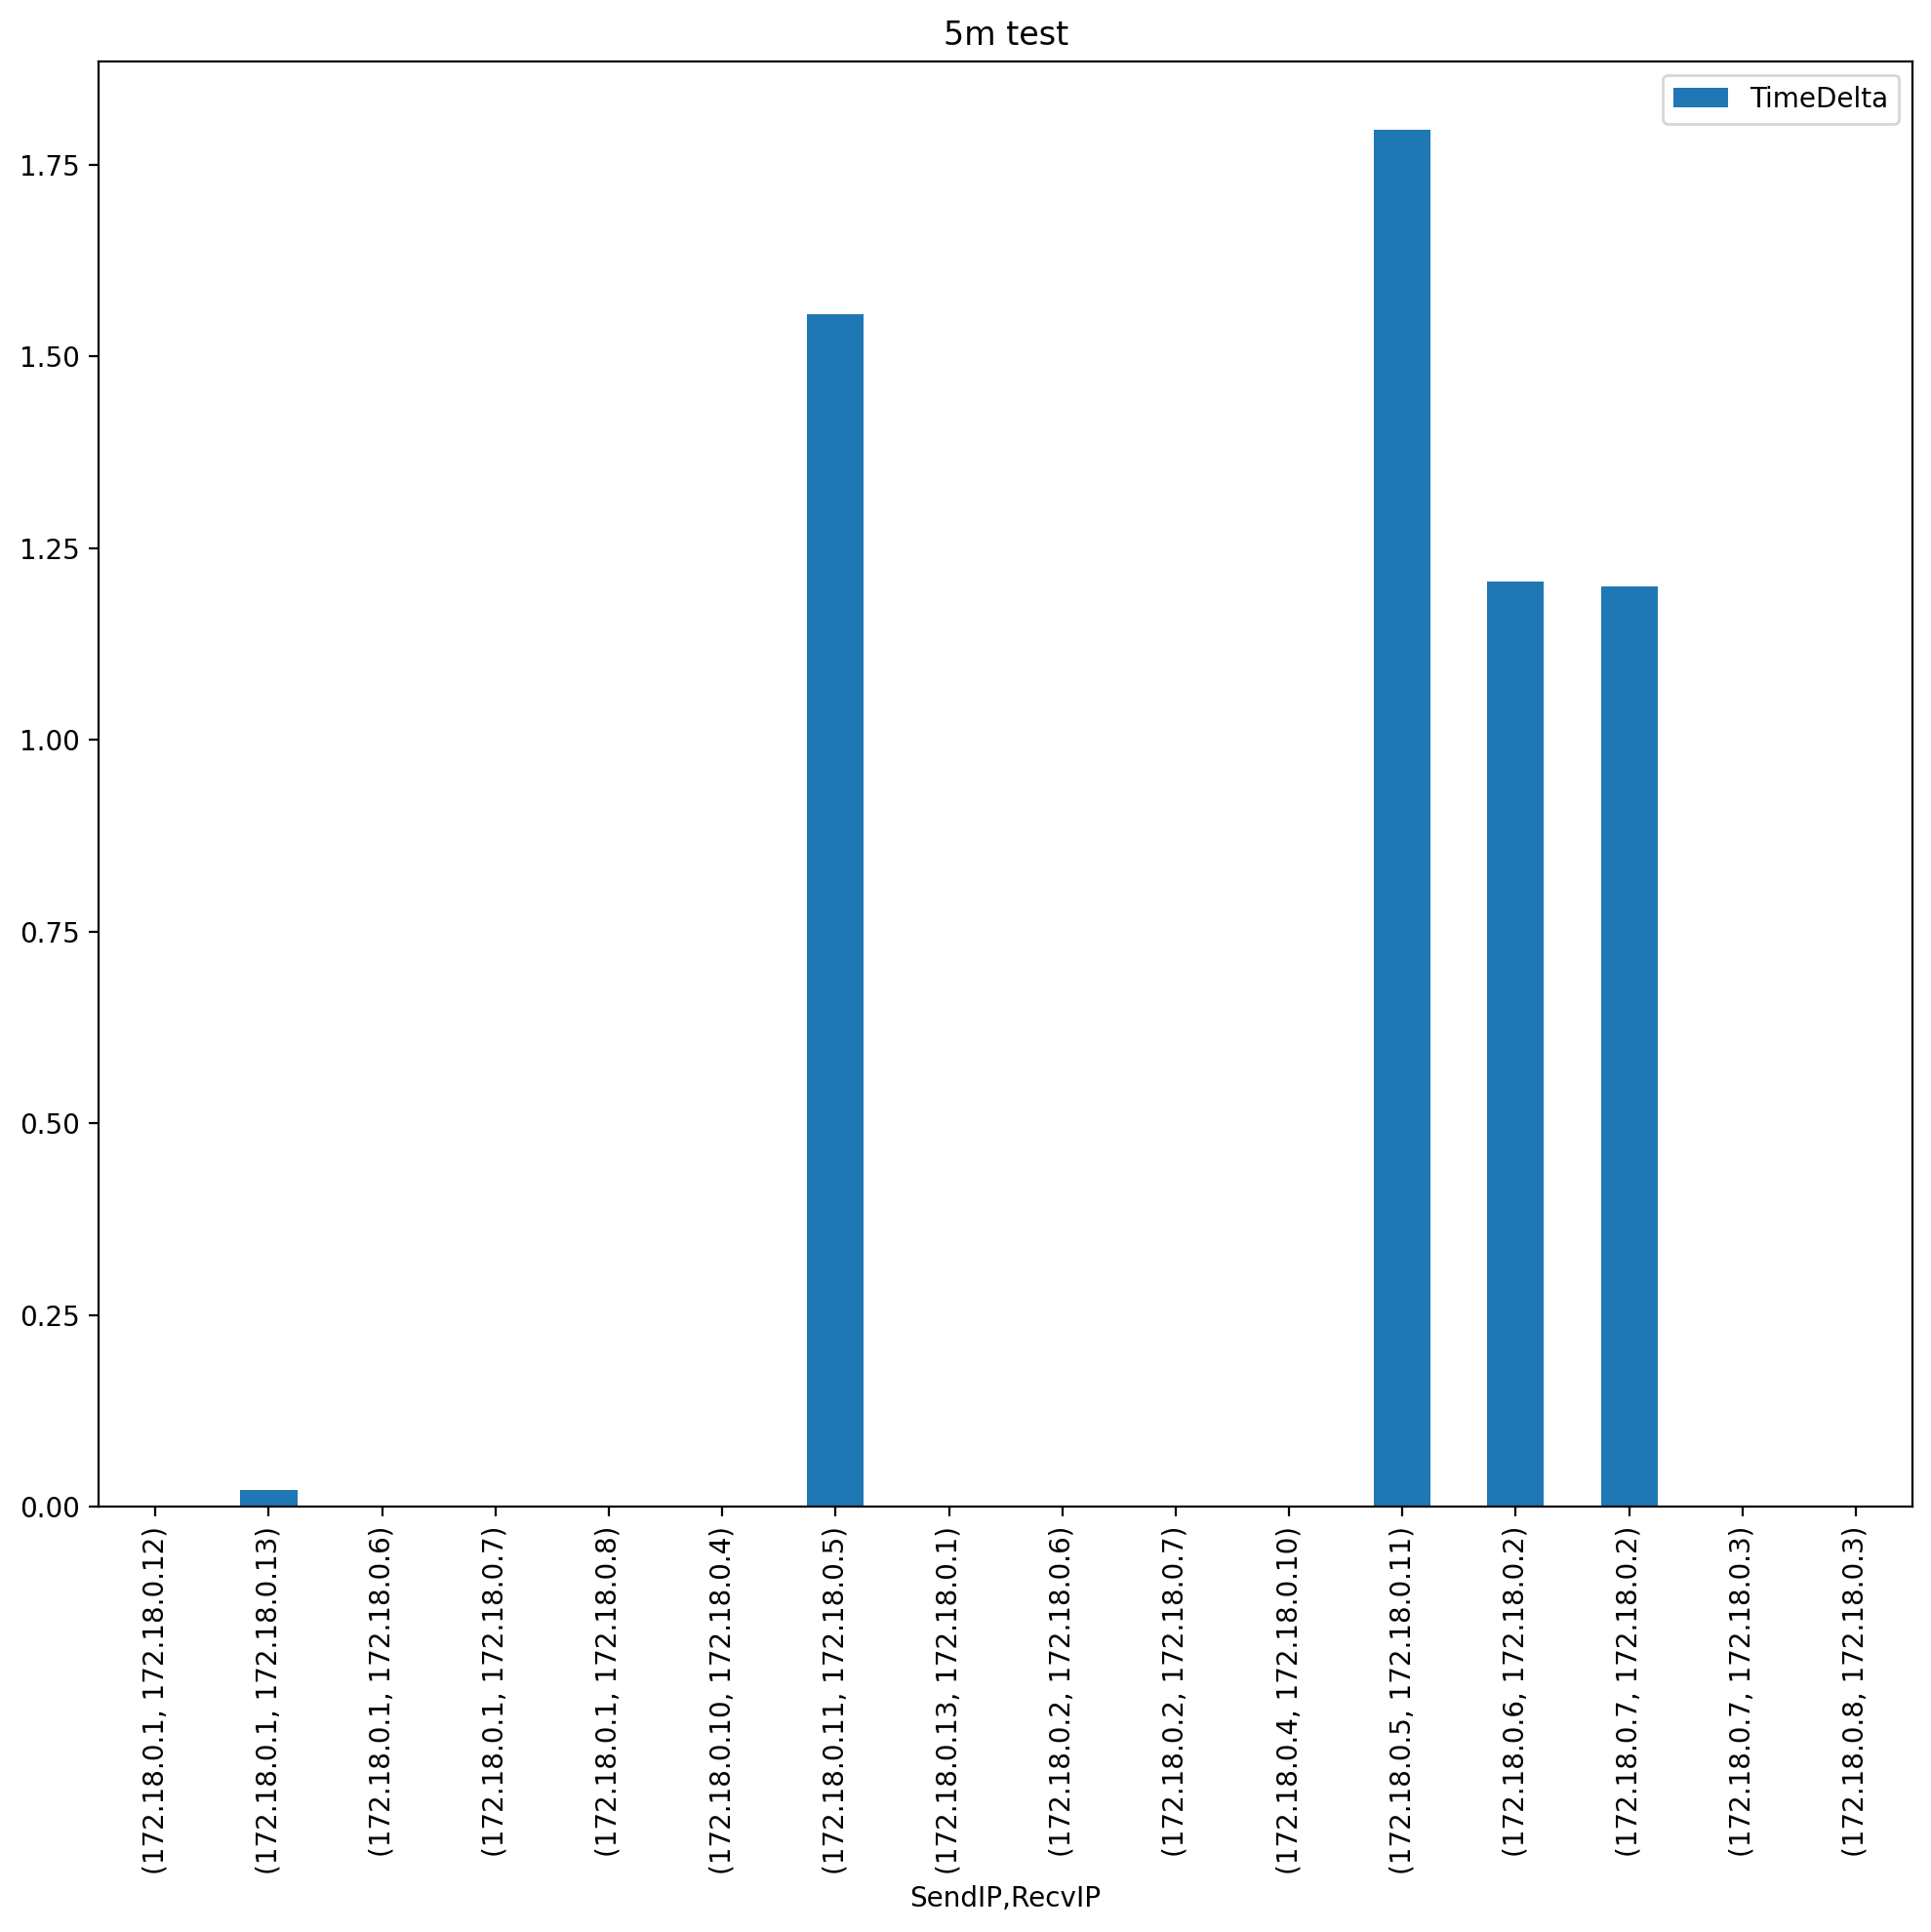

In [19]:
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 1.0)
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 1.0)
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.autolayout"] = True

fg, ax = plt.subplots(nrows=1, ncols=1)

res_test.plot(kind='bar', ax=ax, title=f"{test_duration}{unit} test")

fg.tight_layout()

#plt.savefig("robotshop-30m-10m-3600r-cmp.png")
plt.show()